# Recent Surveys

This notebook evaluates the most recent surveys and is a benchmark to see how good we can predict consumption using the public available data.

In [1]:
cd ..

/Users/emmaboehly/Documents/Master1/Machine Learning/Projet2/MLProjet2/src


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from lib import estimator_util as eu
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
from lib import clusters_utils as cl


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
sns.set_theme()

In [8]:
complete_df, all_cols = eu.get_data("../data/lsms/processed/_all_real.csv", "../data/cnn_features/resnet_trans_all_countries_hyper.csv", "../data/")
countries = ["NG", "ETH" ,"TZA", "MW"]

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=1)
_ = pca.fit(complete_df[all_cols])
features_weights = list(zip(all_cols, pca.components_.T))

## Get names of useless OSM features for the 4 countries

In [10]:
X, _, _, _ = eu.get_recent_osm_features(complete_df, countries, all_cols)
X = pd.DataFrame(X, columns=all_cols)
null_features = X.loc[:, (X == 0).any(axis=0)].keys()

## Predict r^2 for every country in our dataset.

In [11]:
def cnn_osm(complete, model_, country, **params):
    tmp_df = complete.loc[complete.country == country]
    years = tmp_df.groupby(["year"]).groups.keys()
    year = max(years)
    recent_df_complete = tmp_df.loc[tmp_df.year == year]
    split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
    X, y = eu.get_recent_features(tmp_df, [country], all_cols, null_osm_features=null_features)
    r2, y_real, y_predicted, trained_model = eu.run_model(X, y, model_, seed=1, kf= cl.folds_from_split(split_map), **params)
    fig = eu.plot_predictions(y_real, y_predicted, r2, country, year)
    fig.savefig(f"../figs/{country}_{year}_cnnosm_{model_.__name__}.pdf", dpi=600)
    return trained_model

In [12]:
from sklearn.model_selection import GridSearchCV

def optimize_params(complete, model_, params, seed, doPlot=False, k=10):

    countries = ["NG", "ETH", "TZA", "MW"]
    best_params = {"NG":{}, "ETH": {}, "TZA": {}, "MW": {}}
    fig, axs = plt.subplots(len(params.keys()), 1, squeeze=False)
    fig.suptitle('Performance for each hyperparameters')
    for ax in axs.flat:
        ax.set(ylabel='r2')
    for country in tqdm(countries):
        tmp_df = complete.loc[complete.country == country]
        years = tmp_df.groupby(["year"]).groups.keys()
        year = max(years)
        recent_df_complete = tmp_df.loc[tmp_df.year == year]
        split_map = cl.split_k_sets(k, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
        X, y = eu.get_recent_features(tmp_df, [country], all_cols)
        search = GridSearchCV(model_,param_grid=params, scoring='r2', cv=cl.folds_from_split(split_map))
        result = search.fit(X, y)
        for j, key in enumerate(params):
            if doPlot:
                fd = pd.DataFrame.from_dict(result.cv_results_)
                gd = fd.groupby(["param_"+key]).mean()
                axs[j,0].plot(params[key], gd["mean_test_score"], label=country + " - " + key)
                axs[j,0].set(xlabel=key)
                axs[j,0].legend()
            best_params[country].update({key : result.best_params_[key]})
    fig.savefig(f"../figs/{model_.__name__}_optimisation_hyperparameters.pdf", dpi=600)

    return best_params

# Predictions with Ridge Regression

  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/6p/skl5q4mn4kqcwg0hbd513bqr0000gn/T/ipykernel_54765/1100408135.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gd = fd.groupby(["param_"+key]).mean()
 25%|██▌       | 1/4 [00:27<01:22, 27.35s/it]/var/folders/6p/skl5q4mn4kqcwg0hbd513bqr0000gn/T/ipykernel_54765/1100408135.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gd = fd.groupby(["param_"+key]).mean()
 50%|█████     | 2/4 [00:44<00:43, 21.52s/it]/var/folders/6p/skl5q4mn4kqcwg0hbd513bqr0000gn/T/ipykernel_54765/1100408135.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy

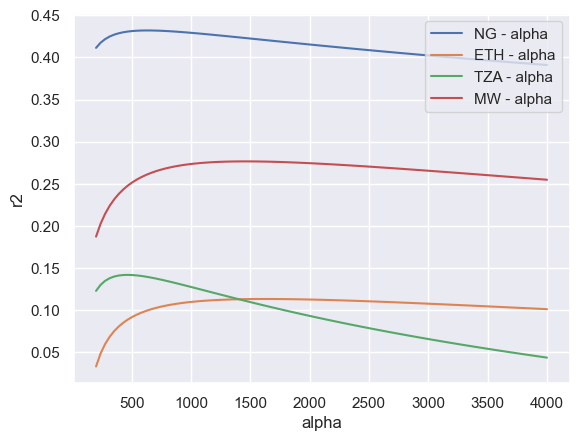

In [13]:
best_params = optimize_params(complete_df, Ridge(), params={'alpha': np.linspace(200, 4000,num=100)}, seed=1, doPlot = True)

In [11]:
for country in countries:
    print(best_params[country]['alpha'])

1044.4444444444443
1773.7373737373737
276.7676767676768
1389.8989898989898


100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


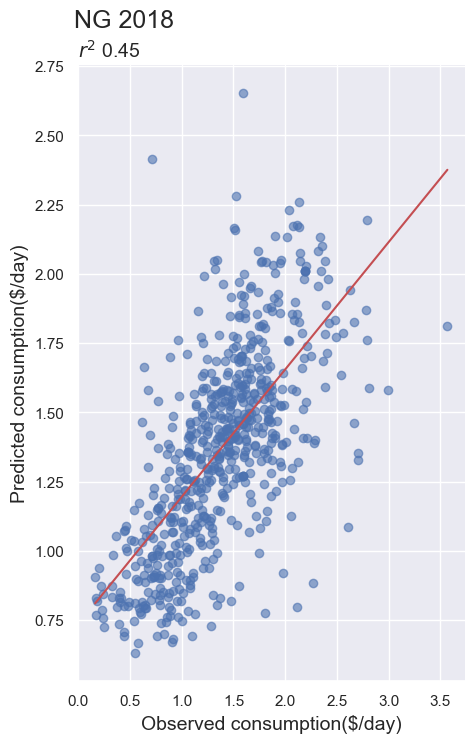

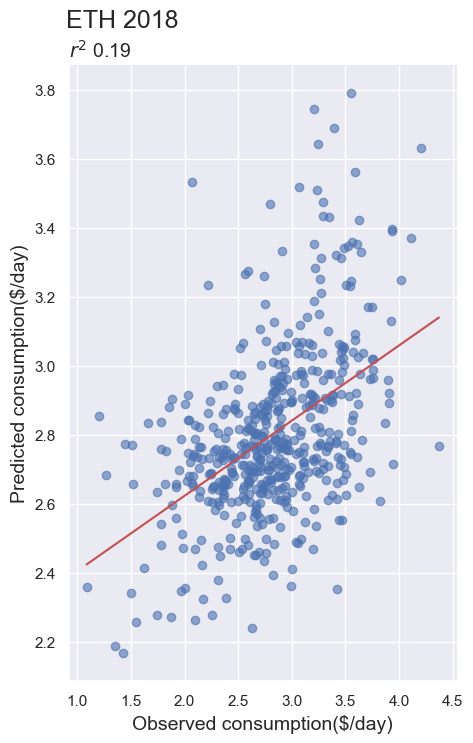

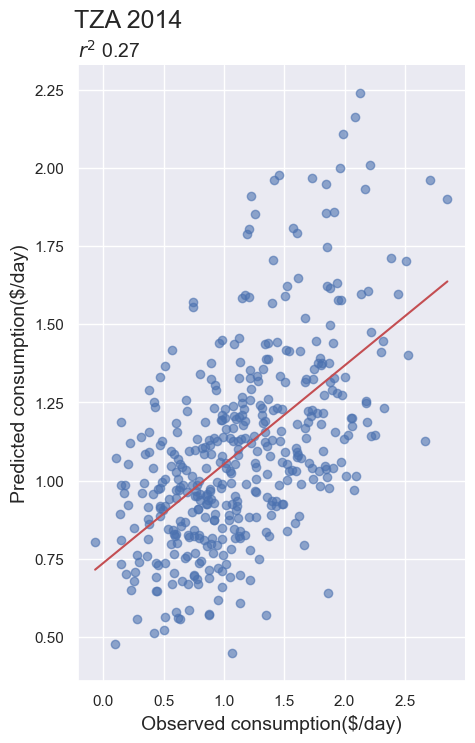

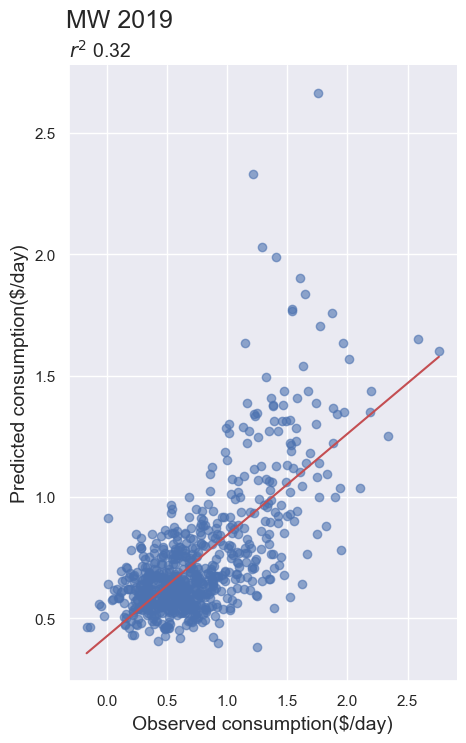

In [12]:
for country in tqdm(countries):
    cnn_osm(complete_df, Ridge, country, alpha = best_params[country]['alpha'])

# Predictions with XGBoost

100%|██████████| 4/4 [10:50<00:00, 162.54s/it]


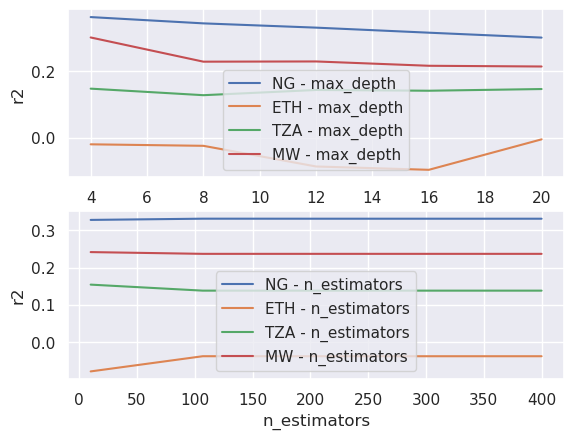

In [19]:
max_depth = np.linspace(4,20, num = 5, dtype=int)
n_estimators = np.linspace(10,400, num = 5, dtype=int)
best_params = optimize_params(complete_df, XGBRegressor(tree_method="gpu_hist", gpu_id=0, random_state=1), params={'max_depth': max_depth, 'n_estimators': n_estimators}, seed=1, doPlot = True, k=10)

In [52]:
print(best_params)

{'NG': {'max_depth': 4, 'n_estimators': 10}, 'ETH': {'max_depth': 20, 'n_estimators': 107}, 'TZA': {'max_depth': 4, 'n_estimators': 10}, 'MW': {'max_depth': 4, 'n_estimators': 10}}


4it [00:19,  4.87s/it]


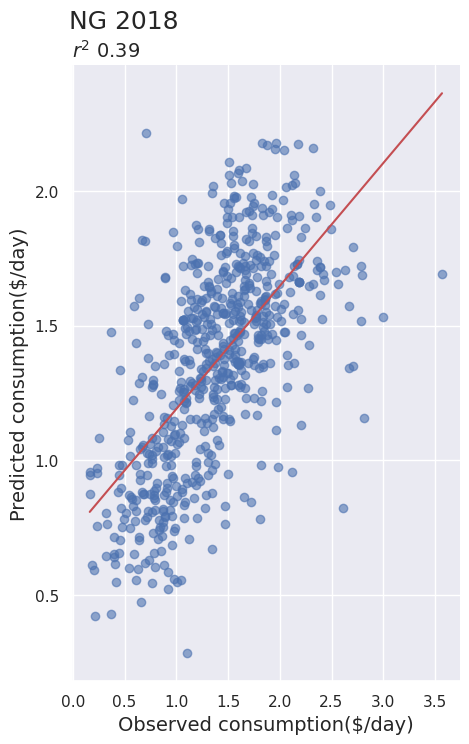

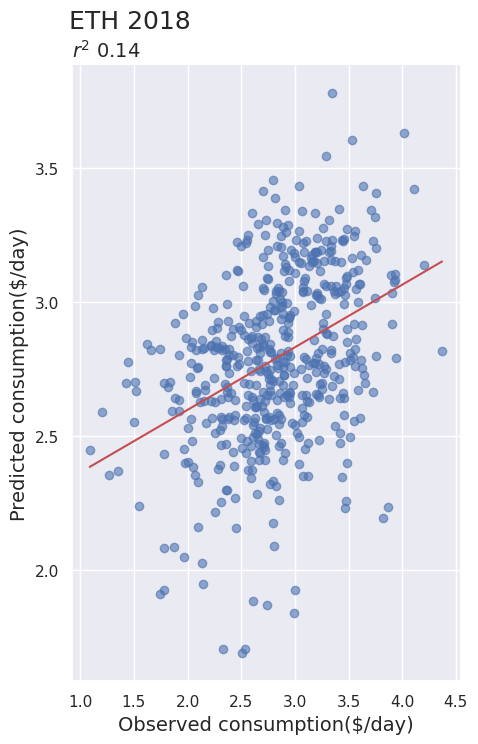

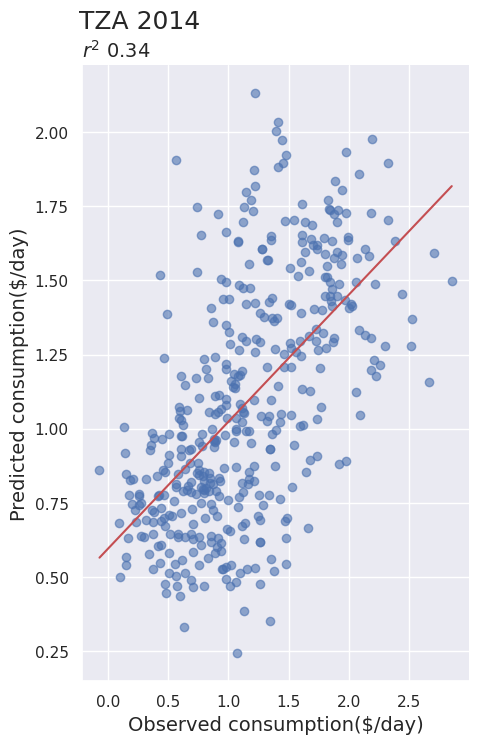

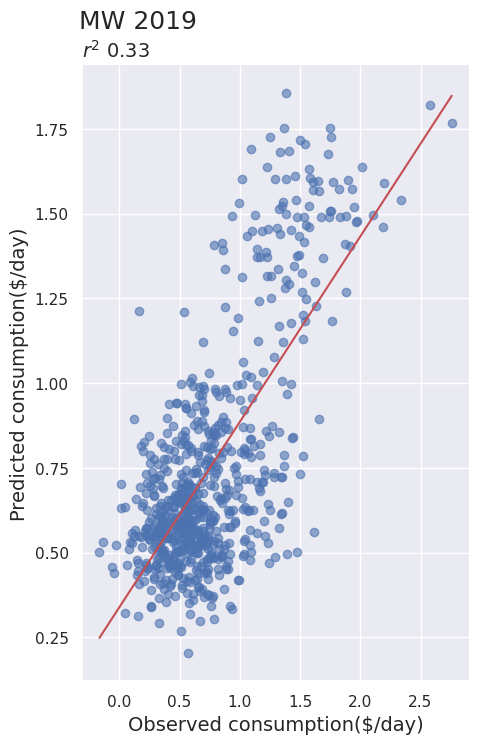

In [21]:
models_xgboost = []
for country, best_param in tqdm(zip(countries, best_params)):
    models_xgboost.append(cnn_osm(complete_df, XGBRegressor, best_param, random_state=42))

# Predictions with CatBoost

In [15]:
    #Can take a lot of time to run, only if computer
best_params = None
#max_depth = np.arange(4,20, step = 3)
#n_estimators = np.arange(50,401, step = 25)
#best_params = optimize_params(complete_df, CatBoostRegressor(), params={'max_depth': max_depth, 'n_estimators': n_estimators}, seed=1)

  0%|          | 0/4 [00:00<?, ?it/s]

Learning rate set to 0.037422
0:	learn: 0.5174234	total: 632ms	remaining: 10m 31s
1:	learn: 0.5102419	total: 933ms	remaining: 7m 45s
2:	learn: 0.5031303	total: 1.34s	remaining: 7m 25s
3:	learn: 0.4964631	total: 1.88s	remaining: 7m 49s
4:	learn: 0.4896886	total: 2.27s	remaining: 7m 31s
5:	learn: 0.4838560	total: 2.54s	remaining: 7m
6:	learn: 0.4773750	total: 2.82s	remaining: 6m 40s
7:	learn: 0.4727213	total: 3.02s	remaining: 6m 14s
8:	learn: 0.4672918	total: 3.22s	remaining: 5m 54s
9:	learn: 0.4617676	total: 3.53s	remaining: 5m 49s
10:	learn: 0.4565259	total: 3.99s	remaining: 5m 58s
11:	learn: 0.4511266	total: 4.18s	remaining: 5m 44s
12:	learn: 0.4467040	total: 4.59s	remaining: 5m 48s
13:	learn: 0.4424079	total: 4.75s	remaining: 5m 34s
14:	learn: 0.4375380	total: 4.96s	remaining: 5m 25s
15:	learn: 0.4328363	total: 5.14s	remaining: 5m 16s
16:	learn: 0.4283799	total: 5.32s	remaining: 5m 7s
17:	learn: 0.4245045	total: 5.46s	remaining: 4m 57s
18:	learn: 0.4201008	total: 5.69s	remaining: 4m 

 25%|██▌       | 1/4 [16:49<50:28, 1009.64s/it]

Learning rate set to 0.035752
0:	learn: 0.5127790	total: 228ms	remaining: 3m 48s
1:	learn: 0.5087828	total: 385ms	remaining: 3m 11s
2:	learn: 0.5048886	total: 504ms	remaining: 2m 47s
3:	learn: 0.5015915	total: 638ms	remaining: 2m 38s
4:	learn: 0.4982505	total: 764ms	remaining: 2m 32s
5:	learn: 0.4946779	total: 892ms	remaining: 2m 27s
6:	learn: 0.4909629	total: 1s	remaining: 2m 22s
7:	learn: 0.4875455	total: 1.16s	remaining: 2m 24s
8:	learn: 0.4840471	total: 1.36s	remaining: 2m 29s
9:	learn: 0.4807038	total: 1.48s	remaining: 2m 26s
10:	learn: 0.4777549	total: 1.69s	remaining: 2m 31s
11:	learn: 0.4752688	total: 1.81s	remaining: 2m 29s
12:	learn: 0.4722599	total: 1.92s	remaining: 2m 25s
13:	learn: 0.4694312	total: 2.09s	remaining: 2m 27s
14:	learn: 0.4667419	total: 2.17s	remaining: 2m 22s
15:	learn: 0.4637567	total: 2.25s	remaining: 2m 18s
16:	learn: 0.4615635	total: 2.33s	remaining: 2m 14s
17:	learn: 0.4590978	total: 2.43s	remaining: 2m 12s
18:	learn: 0.4564879	total: 2.53s	remaining: 2m

 50%|█████     | 2/4 [1:40:29<1:52:17, 3368.87s/it]

Learning rate set to 0.034281
0:	learn: 0.4554569	total: 280ms	remaining: 4m 39s
1:	learn: 0.4509949	total: 387ms	remaining: 3m 12s
2:	learn: 0.4468320	total: 520ms	remaining: 2m 52s
3:	learn: 0.4426495	total: 623ms	remaining: 2m 35s
4:	learn: 0.4385718	total: 717ms	remaining: 2m 22s
5:	learn: 0.4346314	total: 818ms	remaining: 2m 15s
6:	learn: 0.4289773	total: 927ms	remaining: 2m 11s
7:	learn: 0.4247100	total: 996ms	remaining: 2m 3s
8:	learn: 0.4203584	total: 1.14s	remaining: 2m 5s
9:	learn: 0.4165892	total: 1.26s	remaining: 2m 4s
10:	learn: 0.4128561	total: 1.38s	remaining: 2m 4s
11:	learn: 0.4090049	total: 1.51s	remaining: 2m 4s
12:	learn: 0.4048846	total: 1.62s	remaining: 2m 2s
13:	learn: 0.4010280	total: 1.71s	remaining: 2m
14:	learn: 0.3972034	total: 1.79s	remaining: 1m 57s
15:	learn: 0.3941941	total: 1.93s	remaining: 1m 58s
16:	learn: 0.3911048	total: 2.08s	remaining: 2m
17:	learn: 0.3879235	total: 2.23s	remaining: 2m 1s
18:	learn: 0.3850445	total: 2.42s	remaining: 2m 4s
19:	lear

 75%|███████▌  | 3/4 [1:57:39<38:20, 2300.87s/it]  

Learning rate set to 0.037926
0:	learn: 0.4163114	total: 120ms	remaining: 1m 59s
1:	learn: 0.4105266	total: 198ms	remaining: 1m 38s
2:	learn: 0.4051070	total: 338ms	remaining: 1m 52s
3:	learn: 0.3995965	total: 428ms	remaining: 1m 46s
4:	learn: 0.3947755	total: 547ms	remaining: 1m 48s
5:	learn: 0.3899346	total: 624ms	remaining: 1m 43s
6:	learn: 0.3856373	total: 683ms	remaining: 1m 36s
7:	learn: 0.3803652	total: 739ms	remaining: 1m 31s
8:	learn: 0.3756194	total: 808ms	remaining: 1m 29s
9:	learn: 0.3717176	total: 883ms	remaining: 1m 27s
10:	learn: 0.3682624	total: 951ms	remaining: 1m 25s
11:	learn: 0.3641053	total: 1.01s	remaining: 1m 23s
12:	learn: 0.3607037	total: 1.08s	remaining: 1m 22s
13:	learn: 0.3569391	total: 1.15s	remaining: 1m 21s
14:	learn: 0.3525792	total: 1.32s	remaining: 1m 26s
15:	learn: 0.3487238	total: 1.43s	remaining: 1m 27s
16:	learn: 0.3448050	total: 1.52s	remaining: 1m 28s
17:	learn: 0.3409859	total: 1.62s	remaining: 1m 28s
18:	learn: 0.3377689	total: 1.71s	remaining:

100%|██████████| 4/4 [2:14:02<00:00, 2010.57s/it]


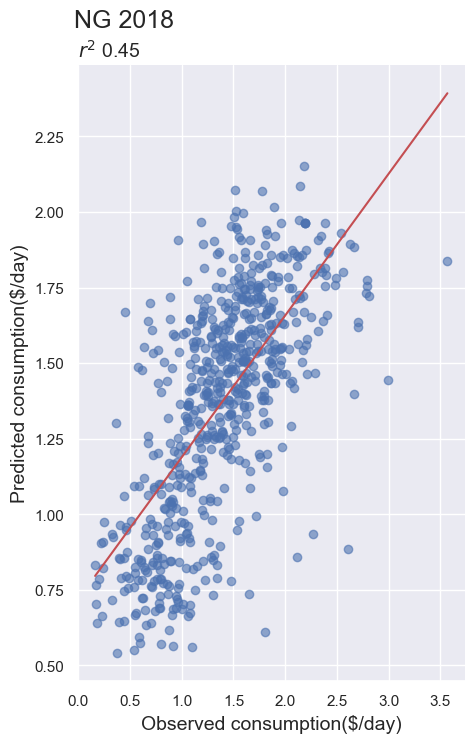

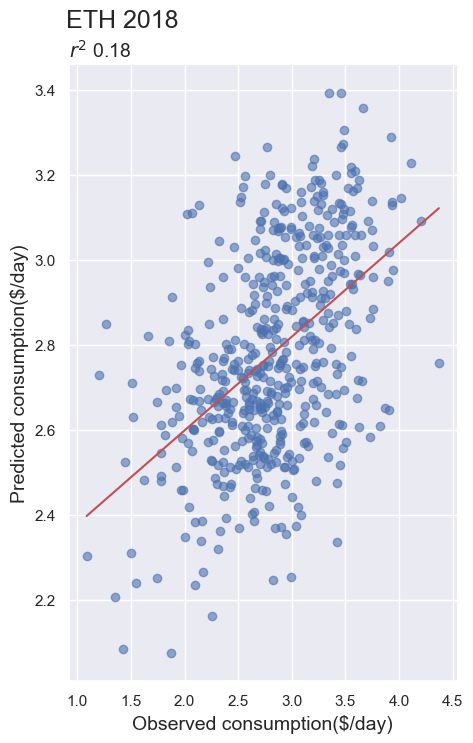

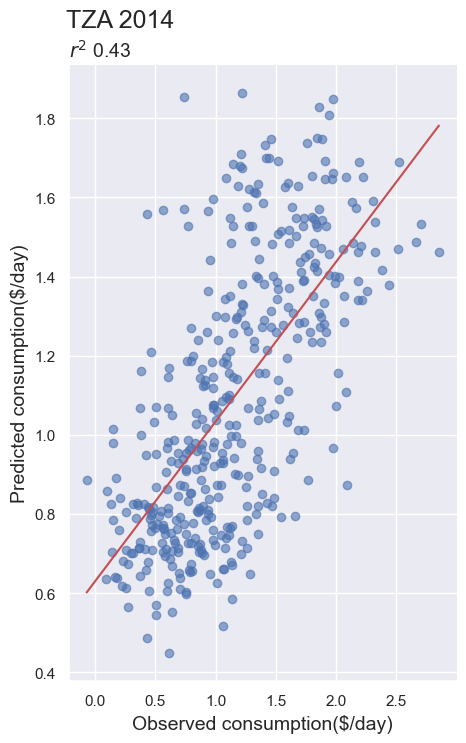

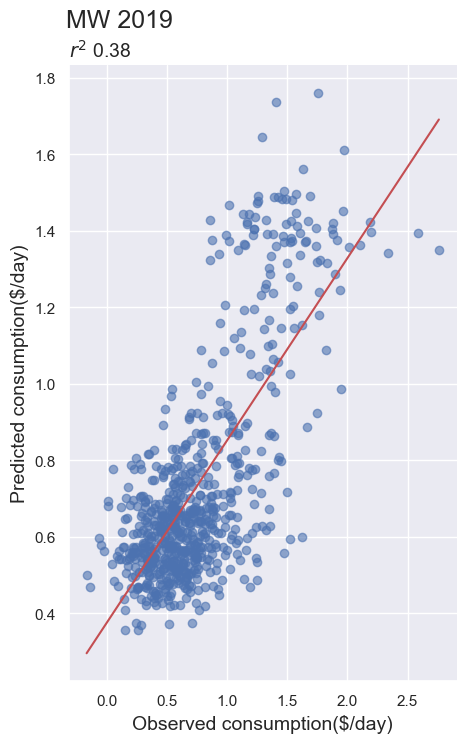

In [17]:
models_catboost = []
if best_params is None:
    for country in tqdm(countries):
        models_catboost.append(cnn_osm(complete_df, CatBoostRegressor, country, task_type="GPU", random_state=42))
else :
    for country, best_param in tqdm(zip(countries, best_params)):
        models_catboost.append(cnn_osm(complete_df, CatBoostRegressor, country, best_param, task_type="GPU", random_state=42))

# Plot features importance

In [ ]:
def features_importance_plot(models) :
    countries = ["NG", "ETH" ,"TZA", "MW"]
    for model, country in tqdm(zip(models,countries)) : 
        importance = model.feature_importances_
        cnn_features_names = [f'cnn{i}' for i in range(len(complete_df.features[0]))]
        features_names = np.concatenate((all_cols, cnn_features_names))
        mask = ~pd.Series(features_names).str.match(r'^cnn')
        
        fig, ax = plt.subplots(figsize=(10, 20))
        sorted_importance, sorted_features = zip(*sorted(zip(importance[mask], features_names[mask])))
        ax.barh(sorted_features, sorted_importance)
        ax.set_yticklabels(sorted_features, fontsize=6)
        
        plt.xlabel('Importance', fontsize=14)
        plt.title(f'Features importance for {country}', fontsize=18)    
        plt.show()
        fig.savefig(f"../figs/{country}_features_importance_{model.__name__}.pdf", dpi=600)

### Features Importance with XGBoost

In [ ]:
features_importance_plot(models_xgboost)

### Features Importance with CatBoost

In [ ]:
features_importance_plot(models_catboost)

## Rural vs. Urban

In [ ]:
def rural_urban(complete, model, **params):    
    types = ["rural", "urban"]
    types_r2 = {}
    rural = []
    ys = []
    y_preds = []
    # get features
    for type in types:    
        r2s = []
        countries = ["NG", "ETH" ,"TZA", "MW"]
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            year_df = year_df.loc[year_df.rural == type]
            rural += year_df.rural.values.tolist()
            cnn_X = np.array([np.array(x) for x in year_df["features"].values])
            osm_X = year_df[all_cols].values
            tmp_X = np.hstack((cnn_X, osm_X))
            y_ = year_df["cons_pc"].values

            if X is None:
                X = tmp_X
            else:
                X = np.vstack((X, tmp_X))
            if y is None:
                y = y_
            else:
                y = np.append(y, y_)

        y = np.log(y)
        ys += y.tolist()
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        r, y_real, y_predicted, _ = eu.run_model(X, y, model, **params)
        y_preds += y_predicted.tolist()
        r2s.append(r)
        types_r2[type] = r2s

    # for the plot
    plt_df = pd.DataFrame.from_dict({"y": ys, "y_pred": y_preds, "rural": rural})

    x_col = "y"
    y_col = "y_pred"
    hue_col = "rural"

    penguins = plt_df
    g = sns.jointplot(data=penguins, x=x_col, y=y_col, hue=hue_col)
    
    for _, gr in penguins.groupby(hue_col):
        sns.regplot(x=x_col, y=y_col, data=gr, scatter=False, ax=g.ax_joint, truncate=False)
    print(types_r2)
    g.ax_joint.set_xlabel("Observed nominal consumption($/day)")
    g.ax_joint.set_ylabel("Predicted nominal consumption($/day)")
    plt.text(-0.8, 1, fr"$r^2 = {round(types_r2['rural'][0], 2)}$", c="#4c72b0")
    plt.text(-0.8, 0.8, fr"$r^2 = {round(types_r2['urban'][0], 2)}$", c="#dd8452")
    plt.legend([],[], frameon=False)
    g.ax_joint.get_legend().remove()
    g.ax_joint.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=g.ax_joint.transAxes)
    plt.savefig("../figs/rural_urban_pop_{model.__name__}.pdf", dpi=600, bbox_inches="tight")


In [ ]:
rural_urban(complete_df)

AttributeError: module 'lib.estimator_util' has no attribute 'run_ridge'

## Predict % of poorest people in dataset

In [ ]:
def pooled_features_perc(complete):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []
        for i in tqdm(np.linspace(0.1,1,91)):
            perc_df = complete.loc[complete.cons_pc <= complete.cons_pc.quantile(i)]
            countries = ["NG", "ETH" ,"TZA", "MW"]
            X = None
            y = None
            for i, country in enumerate(countries):
                tmp_df = perc_df.loc[perc_df.country == country]
                years = tmp_df.groupby(["year"]).groups.keys()
                year = max(years)
                year_df = tmp_df.loc[tmp_df.year == year]
                if feature == "CNN":
                    tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                elif feature == "OSM":
                    tmp_X = year_df[all_cols].values
                else:
                    cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                    osm_X = year_df[all_cols].values
                    tmp_X = np.hstack((cnn_X, osm_X))
                    
                y_ = year_df["cons_pc"].values

                if X is None:
                    X = tmp_X
                else:
                    X = np.vstack((X, tmp_X))
                
                if y is None:
                    y = y_
                else:
                    y = np.append(y, y_)

            recent_df_complete = tmp_df.loc[tmp_df.year == year]
            split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
            y = np.log(y)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            r2, y_real, y_predicted, trained_model = eu.run_model(X, y, Ridge, seed=1, kf= cl.folds_from_split(split_map), alpha=1000)
            r2s.append(r2)
        feature_r2[feature] = r2s
    
    colors = ["#2a9d8f", "#e9c46a", "#e76f51"]
    for i, feature in enumerate(feature_r2):
        plt.plot(np.linspace(0.1,1,91)*100, feature_r2[feature], c=colors[i], label=feature)
    
    plt.xlabel("Poorest percent of cluster used")
    plt.ylabel(r"$r^2$")
    plt.legend()
    ax = plt.gca()
    ax.text(-0.1, 1.1, string.ascii_uppercase[1], size=20, weight='bold', transform=ax.transAxes)
    plt.savefig("../figs/pooled_percentile.pdf", dpi=600, bbox_inches="tight")
    plt.show()

In [ ]:
pooled_features_perc(complete_df)

  0%|          | 0/91 [00:00<?, ?it/s]


AttributeError: module 'lib.estimator_util' has no attribute 'run_ridge'

## Predicting performance from each feature alone and combined

In [9]:
def prediction_features_performance(complete):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []        
        countries = ["NG", "ETH" ,"TZA", "MW"]
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            if feature == "CNN":
                tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                tmp_X = StandardScaler().fit_transform(tmp_X)
            elif feature == "OSM":
                tmp_X = year_df[all_cols].values
            else:
                cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                osm_X = year_df[all_cols].values
                tmp_X = np.hstack((cnn_X, osm_X))
                
            y = year_df["cons_pc"].values

            X = tmp_X
           
            y = np.log(y)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            recent_df_complete = tmp_df.loc[tmp_df.year == year]
            split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
            r2, y_real, y_predicted, trained_model = eu.run_model(X, y, Ridge, seed=1, kf= cl.folds_from_split(split_map), alpha=1000)
            r2s.append(r2)
            feature_r2[feature] = r2s
            
    feat_df = pd.DataFrame.from_dict(feature_r2)
    feat_df["country"] = countries
    return feat_df

In [11]:
prediction_features_performance(complete_df)

,CNN,OSM,CNN+OSM,country
0,0.332698,0.341561,0.495457,NG
1,0.208203,0.246082,0.254799,ETH
2,0.285740,0.406537,0.436564,TZA
3,0.169849,0.473509,0.510650,MW
